# Stock Price Prediction

Let's say we want to make money by buying stocks. Since we want to make money, we only want to buy stock on days when the price will go up (we're against shorting the stock). We'll create a machine learning algorithm to predict if the stock price will increase tomorrow. If the algorithm says that the price will increase, we'll buy stock. If the algorithm says that the price will go down, we won't do anything.

We want to maximize our *true positives* - days when the algorithm predicts that the price will go up, and it actually goes go up. Therefore, we'll be using precision as our error metric for our algorithm, which is *true positives / (false positives + true positives)*. This will ensure that we minimize how much money we lose with *false positives* (days when we buy the stock, but the price actually goes down).

This means that we will have to accept a lot of false negatives - days when we predict that the price will go down, but it actually goes up. This is okay, since we'd rather minimize our potential losses than maximize our potential gains.

## Method

Before we get to the machine learning, we need to do a lot of work to acquire and clean up the data. Here are the steps we'll follow:

- Download historical stock prices from Yahoo finance
- Explore the data
- Setup the dataset to predict future prices using historical prices
- Test a machine learning model
- Setup a backtesting engine
- Improve the accuracy of the model

## Downloading the data

In [1]:
# Import finance API and get historical stock
import yfinance as yf
import os 
import json
import pandas as pd

DATA_PATH = "msft_data.json"

if os.path.exists(DATA_PATH):
    # Read from file if we've already download
    with open(DATA_PATH) as f:
        msft_hist = pd.read_json(DATA_PATH)
else:
    msft = yf.Ticker("MSFT")
    msft_hist = msft.history(period = "max")
    # Save file to json in case we need it later
    msft_hist.to_json(DATA_PATH)

# Display microsoft stock price history so we can look at the structure of the data
msft_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13,0.055654,0.063838,0.055654,0.061109,1031788800,0.0,0.0
1986-03-14,0.061109,0.064384,0.061109,0.063292,308160000,0.0,0.0
1986-03-17,0.063292,0.064929,0.063292,0.064383,133171200,0.0,0.0
1986-03-18,0.064383,0.064929,0.062201,0.062746,67766400,0.0,0.0
1986-03-19,0.062746,0.063292,0.061109,0.061655,47894400,0.0,0.0


As we can see, we have one row of data for each day that Microsoft stock was traded. Here are the columns:

- Open - the price the stock opened at.
- High - the highest price during the day
- Low - the lowest price during the day
- Close - the closing price on the trading day
- Volume - how many shares were traded
  
Stock doesn't trade every day (there is no trading on weekends and holidays), so some dates are missing

Next, we'll plot the data so we can see how the stock price has changed over time. This gives us another overview of the structure of the data.

<AxesSubplot:>

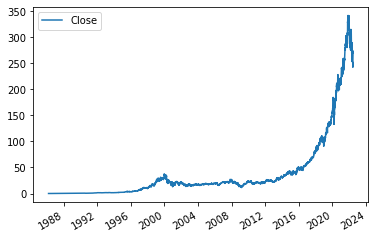

In [2]:
msft_hist.plot.line(y="Close", use_index=True)

 ## Preparing the data

 Ok, hopefully you've stopped kicking yourself for not buying Microsoft stock at any point in the past 30 years now.

Now, let's prepare the data so we can make predictions. We'll be predicting if the price will go up or down tomorrow based on data from today.

First, we'll identify a target that we're trying to predict. Our target will be if the price will go up or down tomorrow. If the price went up, the target will be *1* and if it went down, the target will be *0*.

Next, we'll shift the data from previous days "forward" one day, so we can use it to predict the target price. This ensures that we don't accidentally use data from the same day to make predictions! (a very common mistake)

Then, we'll combine both so we have our training data.

In [3]:
# Ensure we know the actual closing price
data = msft_hist[['Close']]
data = data.rename(columns={'Close':'Actual_Close'})
# Setup our target.  This identifies if the price went up or dow
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1]> x.iloc[0])["Close"]

In [4]:
data.head()

,Actual_Close,Target
1986-03-13,0.061109,NaN
1986-03-14,0.063292,1.0
1986-03-17,0.064383,1.0
1986-03-18,0.062746,0.0
1986-03-19,0.061655,0.0


In [5]:
# Shift stock prices forward one day, so we're predicting tomorr
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)
msft_prev.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14,0.055654,0.063838,0.055654,0.061109,1.031789e+09,0.0,0.0
1986-03-17,0.061109,0.064384,0.061109,0.063292,3.081600e+08,0.0,0.0
1986-03-18,0.063292,0.064929,0.063292,0.064383,1.331712e+08,0.0,0.0
1986-03-19,0.064383,0.064929,0.062201,0.062746,6.776640e+07,0.0,0.0


In [6]:
# Create our training data
predictors = ["Close","High","Low","Open","Volume"]
data = data.join(msft_prev[predictors]).iloc[1:]
data.head()

,Actual_Close,Target,Close,High,Low,Open,Volume
1986-03-14,0.063292,1.0,0.061109,0.063838,0.055654,0.055654,1.031789e+09
1986-03-17,0.064383,1.0,0.063292,0.064384,0.061109,0.061109,3.081600e+08
1986-03-18,0.062746,0.0,0.064383,0.064929,0.063292,0.063292,1.331712e+08
1986-03-19,0.061655,0.0,0.062746,0.064929,0.062201,0.064383,6.776640e+07
1986-03-20,0.060018,0.0,0.061655,0.063292,0.061109,0.062746,4.789440e+07


## Creating machine learning model

Next, we'll create a machine learning model to see how accurately we can predict the stock price.

Because we're dealing with time series data, we can't just use cross-validation to create predictions for the whole dataset. This will cause leakage where data from the future will be used to predict past prices. This doesn't match with the real world, and will make us think that our algorithm is much better than it actually is.

Instead, we'll split the data sequentially. We'll start off by predicting just the last 100 rows using the other rows.

We'll use a random forest classifier to generate our predictions. This is a good "default" model for a lot of applications, because it can pick up nonlinear relationships in the data, and is somewhat robust to overfitting with the right parameters.

In [7]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100,min_samples_split=200, random_state=1)
# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors],train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

Next, we'll need to check how accurate the model was. Earlier, we mentioned using precision to measure error. We can do this by using the precision_score function from scikit-learn.

In [8]:
from sklearn.metrics import precision_score
# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index= test.index)
preds

2022-01-25    1.0
2022-01-26    1.0
2022-01-27    0.0
2022-01-28    1.0
2022-01-31    1.0
             ... 
2022-06-10    1.0
2022-06-13    1.0
2022-06-14    1.0
2022-06-15    1.0
2022-06-16    1.0
Length: 100, dtype: float64

In [9]:
preds.value_counts()

1.0    93
0.0     7
dtype: int64

In [10]:
precision_score(test["Target"], preds)

0.45161290322580644

So our model is directionally accurate 45% of the time. This is only a little bit better than a coin flip! We can take a deeper look at the individual predictions and the actuals, and see where we're off.

In [11]:
combined = pd.concat({"Target": test["Target"],"Prediction":preds}, axis=1)
combined.head()

,Target,Prediction
2022-01-25,0.0,1.0
2022-01-26,1.0,1.0
2022-01-27,1.0,0.0
2022-01-28,1.0,1.0
2022-01-31,1.0,1.0


<AxesSubplot:>

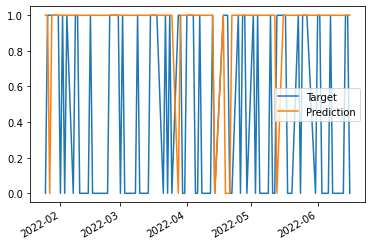

In [12]:
combined.plot()

## Backtesting Engine

Our model isn't great, but luckily we can still improve it. Before we do that, let's figure out how to make predictions across the entire dataset, not just the last 100 rows. This will give us a more robust error estimate. The last 100 days may have has atypical market conditions or other issues that make error metrics on those days unrealistic for future predictions (which are what we really care about).

To do this, we'll need to backtest. Backtesting ensures that we only use data from before the day that we're predicting. If we use data from after the day we're predicting, the algorithm is unrealistic (in the real world, you won't be able to use future data to predict that past!).

Our backtesting method will loop over the dataset, and train a model every 750 rows. We'll make it a function so we can avoid rewriting the code if we want to backtest again.

In the backtesting function, we will:

Split the training and test data
Train a model
Make predictions on the test data using predict_proba - this is because we want to really optimize for true positives. By default, the threshold for splitting 0/1 is .5, but we can set it to different values to tweak the precision. If we set it too high, we'll make fewer trades, but will have a lower potential for losses.

In [13]:
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    for i in range(start,data.shape[0],step):

        train = data.iloc[:i].copy()
        test = data.iloc[i:(i+step)].copy()

        model.fit(train[predictors],train["Target"])
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds <= .6] = 0

        combined = pd.concat({"Target":test["Target"],"Predictions":preds}, axis=1)
        predictions.append(combined)
    return pd.concat(predictions)

#predictions["Predictions"].value_counts()


In [14]:
predictions = backtest(data,model,predictors)
predictions["Predictions"].value_counts()

0.0    7513
1.0     627
Name: Predictions, dtype: int64

As you can see, we're only making 627 trades. This is because we used .6 as a threshold for trading.

In [15]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5119617224880383

## Improving accuracy

The model isn't very accurate, but at least now we can make predictions across the entire history of the stock. For this model to be useful, we have to get it to predict more accurately.

Let's add some more predictors to see if we can improve accuracy.

We'll add in some rolling means, so the model can evaluate the current price against recent prices. We'll also look at the ratios between different indicators.

In [16]:
weekly_mean = data.rolling(7).mean()
quaterly_mean = data.rolling(90).mean()
annual_mean = data.rolling(365).mean()

weekly_trend = data.shift(1).rolling(7).mean()["Target"]


In [17]:
data["weekly_mean"] = weekly_mean["Close"] / data["Close"]
data["quaterly_mean"] = quaterly_mean["Close"] / data["Close"]
data["annual_mean"] = annual_mean["Close"] / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quaterly_mean"]
data["weekly_trend"] = data["annual_mean"] / data["weekly_mean"]

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

full_predictors = predictors + ["weekly_mean","quaterly_mean","annual_mean","annual_weekly_mean","annual_quarterly_mean","weekly_trend","open_close_ratio","high_close_ratio","low_close_ratio"]

In [18]:
predictions = backtest(data.iloc[365:], model, full_predictors)

In [19]:
precision_score(predictions["Target"],predictions["Predictions"])

0.5517241379310345

In [20]:
predictions["Predictions"].value_counts()

0.0    7456
1.0     319
Name: Predictions, dtype: int64

<AxesSubplot:>

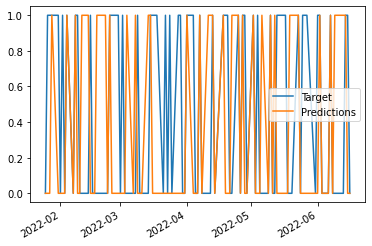

In [21]:
predictions.iloc[-100:].plot()

## Extra
### 1- Improve the algorithm
- Run with a reduced step size! This will take longer, but increase accuracy

In [22]:
predictions = backtest(data.iloc[365:], model, full_predictors, step=365)
precision_score(predictions["Target"], predictions["Predictions"])

0.5905044510385756